<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Supply_Planning_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting Up**

In [69]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
%%capture
!pip install pulp
!pip install gurobipy

In [71]:
import pandas as pd
import numpy as np

# Optimization libraries

import cvxpy as cp
from pulp import *
from gurobipy import Model, GRB

import os
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

plt.style.use("ggplot")
COLORS = list(sns.color_palette())
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

# **Costs Data**
## **Inbound Costs**

In [72]:
shared_path = 'drive/My Drive/data/Supply_chain_case_study'

In [73]:
# Inbound Costs
df_inbound = pd.read_csv(os.path.join(shared_path, 'inbound_price.csv'), index_col = 0)
df_inbound

,FROM,D1,D2
0,P1,3.0,5.0
1,P2,2.3,6.6


## **Outbound Costs**

In [74]:
# Outbound Costs
df_outbound = pd.read_csv(os.path.join(shared_path, 'outbound_price.csv'), index_col = 0)
df_outbound

,from,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
0,D1,2.30,4.23,2.26,3.38,1.59,2.01,5.32,6.63,2.38,...,5.86,8.30,3.02,1.01,2.77,2.96,3.53,8.60,2.77,7.06
1,D2,5.31,2.18,8.52,8.34,4.59,1.04,1.89,6.45,8.35,...,7.54,2.11,4.33,1.54,4.75,7.84,8.21,4.51,3.27,3.13


## **Merging Two Costs**

In [75]:
# Melting DataFrame
df_melt = pd.melt(df_outbound.set_index('from').T.reset_index().rename_axis(None, axis=1).rename(columns = {'index': 'Store'}),
                  id_vars=['Store'], value_vars=['D1', 'D2'], var_name = 'Distribution')
print(f'Number of records: {len(df_melt)}')
df_melt.head()

Number of records: 400


,Store,Distribution,value
0,S1,D1,2.30
1,S2,D1,4.23
2,S3,D1,2.26
3,S4,D1,3.38
4,S5,D1,1.59


## **Plotting Outbound Transportation Costs**

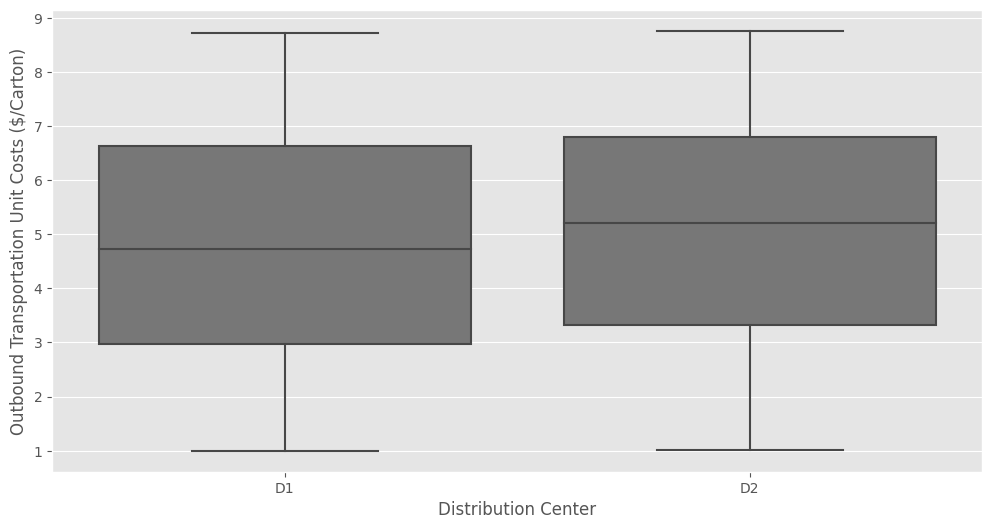

In [76]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Distribution', y='value', data=df_melt, color=COLORS[3])
plt.xlabel('Distribution Center')
plt.ylabel('Outbound Transportation Unit Costs ($/Carton)')
plt.show()

# **Constructing Assumption**
## **Production Plant Capacity**

In [77]:
# Production capacity
df_prod = pd.DataFrame({
    'plant': ['P1','P2'],
    'max': [200, 400],
})[['plant', 'max']]
df_prod

,plant,max
0,P1,200
1,P2,400


In [78]:
# Cross-Docking Capacity
df_t = pd.DataFrame({
    'DC': ['D1','D2'],
    'CAPACITY': [500, 300]
})[['DC', 'CAPACITY']]
df_t

,DC,CAPACITY
0,D1,500
1,D2,300


## **Demand**

In [79]:
# Demand
df_demand = pd.read_csv(os.path.join(shared_path, 'demand.csv'), index_col = 0)
print(f'Total demand in all store: {df_demand.DEMAND.sum()}')
df_demand.head()

Total demand in all store: 31806


,STORE,DEMAND
0,D1,244
1,D2,172
2,D3,124
3,D4,90
4,D5,158


# **Establishing the Optimization Model**

## **Problem Statement**

**Assumptions**
+ 2 plants producing products with infinite capacity (for simplicity)
+ 2 distribution centres receiving finished products from two plants and delivering them to customers (using Cross-Docking process)
+ 200 stores (served as delivery points)

**Notations**

$P_i:$ plant $i$ with $i \in [1, 2]$

$D_i:$ distribution center $i$ with $i \in [1, 2]$

$S_i:$ store $i$ with $i \in [1, 200]$

$D_p:$ demand of store $p$ with $p \in [1, 200]$

$I_{n, p}:$ quantity transported from **plant** $n$ to **distribution center** $p$

$O_{n, p}:$ quantity transported from **distribution center** $n$ to **store** $p$

$IC_{n, p}:$ inbound transportation costs between plant $n$ and distribution center $p$

$OC_{n, p}:$ outbound transportation costs between distribution center $n$ and store $p$

## **Setting up Components**

1. Decision Variables

$$I_{n, p} \text{ and } O_{n, p}$$

2. Optimization Problem

Let
$$\text{TC} = \sum_{n=1}^{2} \sum_{p=1}^{2} IC_{n, p} \ast I_{n, p} + \sum_{n=1}^{2} \sum_{p=1}^{200} OC_{n, p} \ast O_{n, p}.$$

Then, our optimization problem is

$$
\begin{aligned}
\min_{I_{n, p},\, O_{n, p}} \quad & \text{TC}\\
\textrm{s.t.} \quad & \sum_{n=1}^{2} O_{n, p} \geq D_{p}, \quad p \in [1, 200] \\
& \sum_{n=1}^{2} I_{n, p} = \sum_{n=1}^{200} O_{p, n}, \quad p \in [1, 2]
\end{aligned}
$$

The first constraint indicates that the total quantity transported from the two distribution centers must be at least the demand, while the second one implies that the supply from the distribution centers must meet the demand of each store.

# **PuLP**

In [80]:
# 1. Initiliaze Class
model = LpProblem("Transhipment_Problem", LpMinimize)

# 2. Define Decision Variables
# Inbound Flows
I = LpVariable.dicts("I", [(i+1,j+1) for i in range(2) for j in range(2)],
                     lowBound=0, upBound=None, cat='Integer') # I(i,j) from plant i for platform j
# Outbound Flows
O = LpVariable.dicts("O", [(i+1,j+1) for i in range(2) for j in range(200)],
                     lowBound=0, upBound=None, cat='Integer') # O(i,j) from platform i for customer j

# 3. Define Objective Function
# Total Transportation Cost
model += lpSum([df_inbound.iloc[i,j+1] * I[i+1,j+1] for i in range(2) for j in range(2)]) + lpSum([df_outbound.iloc[i,j+1] * O[i+1,j+1] for i in range(2) for j in range(200)])


# 4. Define Constraints
# Max capacity for plants
# for i in range(5):
#     model += lpSum([I[i+1, j+1] for j in range(2)]) <= df_prod.loc[i,'max']
# Shipment from DCs higher than demand per store
for j in range(200):
    model += lpSum([O[i+1, j+1] for i in range(2)]) >= df_demand.loc[j,'DEMAND']
# Conservation of the flow in the local DC (X-Docking Platform)
for p in range(2):
    model += lpSum([I[i+1, p+1] for i in range(2)]) == lpSum([O[p+1, j+1] for j in range(200)])
# Maximum Inbound Capacity in Platform i
# for p in range(2):
#     model += lpSum([I[i+1, p+1] for i in range(5)]) <= df_t.loc[p,'capacity']

# Solve Model
status = model.solve()
print(LpStatus[status])
print("Objective: z* = {}".format(
    value(model.objective)))

# Matrix result
inbound, outbound = np.zeros([2,2]), np.zeros([2,200])
for i in range(2):
    for j in range(2):
#         print(I[i+1, j+1].varValue, I[i+1, j+1].name)
        inbound[i, j] = I[i+1, j+1].varValue
for i in range(2):
    for j in range(200):
#         print(O[i+1, j+1].varValue, O[i+1, j+1].name)
        outbound[i, j] = O[i+1, j+1].varValue

Optimal
Objective: z* = 217189.3199999999


# **CVXPy**

In [81]:
# 1. Define Decision Variables
# Inbound Flows
I = cp.Variable((2, 2), integer=True)
# Outbound Flows
O = cp.Variable((2, 200), integer=True)

# 2. Define Objective Function
# Total Transportation Cost
objective = cp.Minimize(cp.sum(cp.multiply(np.array(df_inbound.iloc[:,1:]), I)) + cp.sum(cp.multiply(np.array(df_outbound.iloc[:,1:]), O)))

# 3. Define Constraints
constraints = []

# Shipment from DCs higher than demand per store
for j in range(200):
    constraints.append(cp.sum(O[:, j]) >= df_demand.loc[j,'DEMAND'])

# Conservation of the flow in the local DC (X-Docking Platform)
for p in range(2):
    constraints.append(cp.sum(I[:, p]) == cp.sum(O[p, :]))

# 4. Solve Model
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.GLPK_MI)

print("Status:", prob.status)
print("Objective: z* =", prob.value)

# Matrix result
inbound, outbound = I.value, O.value


Status: unbounded
Objective: z* = -inf


# **GUROPY**

In [82]:
# 1. Initialize Model
model = Model("Transhipment_Problem")

# 2. Define Decision Variables
# Inbound Flows
I = model.addVars([(i+1,j+1) for i in range(2) for j in range(2)],
                  lb=0, vtype=GRB.INTEGER, name="I") # I(i,j) from plant i for distribution center j
# Outbound Flows
O = model.addVars([(i+1,j+1) for i in range(2) for j in range(200)],
                  lb=0, vtype=GRB.INTEGER, name="O") # O(i,j) from distribution center i for store j

# 3. Define Objective Function
# Total Transportation Cost
model.setObjective(sum(df_inbound.iloc[i,j+1] * I[i+1,j+1] for i in range(2) for j in range(2)) + sum(df_outbound.iloc[i,j+1] * O[i+1,j+1] for i in range(2) for j in range(200)), GRB.MINIMIZE)

# 4. Define Constraints
# Shipment from DCs higher than demand per store
for j in range(200):
    model.addConstr(sum(O[i+1, j+1] for i in range(2)) >= df_demand.loc[j,'DEMAND'])
# Conservation of the flow in the local DC (Cross-Docking Platform)
for p in range(2):
    model.addConstr(sum(I[i+1, p+1] for i in range(2)) == sum(O[p+1, j+1] for j in range(200)))

# Solve Model
model.optimize()

print("Status:", model.status)
print("Objective: z* =", model.objVal)

# Matrix result
inbound = np.zeros([2,2])
outbound = np.zeros([2,200])
for i in range(2):
    for j in range(2):
        inbound[i, j] = I[i+1, j+1].x
for i in range(2):
    for j in range(200):
        outbound[i, j] = O[i+1, j+1].x

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 202 rows, 404 columns and 804 nonzeros
Model fingerprint: 0xe5035306
Variable types: 0 continuous, 404 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+02]
Found heuristic solution: objective 290103.22000
Presolve removed 202 rows and 404 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 217189 290103 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.171893200000e+05, best bound 2.171893200000e+05, gap 0.0000%
Status: 2
Objective: z* = 217189.31999999998


**PuLP**

Optimal
Objective: z* = 217189.3199999999
D1: 25574
D2: 6232

**GUROPY**

Optimal
Objective: z* = 217189.3199999999
D1: 25574
D2: 6232

**CVXPy**

Optimal
Objective: z* = -Inf

# **Results**

In [85]:
# Inbound flow
df_resin = pd.DataFrame(data = inbound, index =['P' + str(i+1) for i in range(2)],
                        columns = ['D' + str(i+1) for i in range(2)]).astype(int)
df_resin

,D1,D2
P1,0,6232
P2,25574,0


In [84]:
# Outbound flow
df_resout = pd.DataFrame(data = outbound, index =['D' + str(i+1) for i in range(2)],
                        columns = ['S' + str(i+1) for i in range(200)])
df_resout.T

,D1,D2
S1,244.0,-0.0
S2,172.0,-0.0
S3,124.0,-0.0
S4,90.0,-0.0
S5,158.0,-0.0
...,...,...
S196,57.0,-0.0
S197,52.0,-0.0
S198,-0.0,243.0
S199,70.0,-0.0


The most saving-cost route for Inbound is by connecting Plant 2 with Distribution center 1 and vice versa.